# Setup

In [1]:
%load_ext autoreload
%autoreload 2
from dsets.dsets import ENGLISH_DATASETS, get_datasets, JAPANESE_DATASETS
from dsets.dset_config.dset_config import DatasetConfig

from dsets.helpers.helpers import apply_parallel, get_sampling_rates
from itpsaudio.transforms import * 
from itpsaudio.core import * 

/home/jjs/.conda/envs/itps-env/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
!nvidia-smi

Fri May 27 11:14:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   59C    P8    13W /  N/A |      8MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports 

In [3]:
from fastai.data.all import * 
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForMaskedLM, AutoTokenizer, Wav2Vec2Processor, Wav2Vec2ForCTC
from datasets import load_dataset
from fastai.text.all import * 
from fastai.vision.all import *
from fastai.callback.tensorboard import *
import torchaudio
from fastai.callback.neptune import NeptuneCallback
import neptune 
import pandas
import MeCab
from pathlib import Path
from IPython.display import Audio, display
import japanize_matplotlib
import jiwer
import pickle
from datasets import load_metric
dset_lengths = None
TEST_RUN=False

In [4]:
datasets = [
    # DatasetConfig(name='itps', split='train', lang='en', kind=None),
    DatasetConfig(name='librispeech', split='dev', lang=None, kind='clean'),
    # DatasetConfig(name='librispeech', split='train', lang=None, kind='clean'),
    # DatasetConfig(name='librispeech', split='train', lang=None, kind='other'),
    DatasetConfig(name='ljl', split='train', lang=None, kind=None),
    DatasetConfig(name='nict_spreds', split='train', lang='en', kind=None)
 ]

if TEST_RUN:
  if datasets == []:
    p, df = get_datasets([ENGLISH_DATASETS[0]])
  else:
    p, df = get_datasets([datasets[0]])
else:
  if datasets == []:
    df = load_dataset("common_voice", "en",split="train")
  else:
    p, df = get_datasets(datasets)
if os.path.exists("df.pkl"):
  df = pd.read_pickle("df.pkl")


# Model Training

In [5]:
from functools import lru_cache
@lru_cache(maxsize=None)
def get_audio_length(s):
  t, sr = torchaudio.load(s)
  return len(t[0])/sr

In [6]:
import os
en_vocab = ("assets/en_vocab.json")

In [7]:
from transformers import Wav2Vec2CTCTokenizer
wav2vec2tok = Wav2Vec2CTCTokenizer(en_vocab,bos_token="[BOS]",
                                   eos_token="[EOS]",
                                   unk_token="[UNK]",
                                   pad_token="[PAD]",

                                   )
tok = ENTransformersTokenizer(tok=wav2vec2tok)

In [8]:
if not "audio_length" in df.columns:
  df["audio_length"] = df["filename"].apply(get_audio_length).copy()

In [9]:
df["audio_length"].max()

14.995

<AxesSubplot:ylabel='Frequency'>

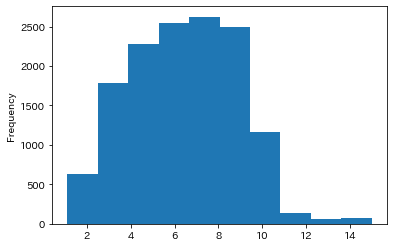

In [10]:
df["audio_length"].plot.hist()

In [11]:
df["audio_length"].sum() / 60 / 60

24.597875189397516

In [12]:
MAX_AUDIO_LENGTH=15
df = df[df["audio_length"]<MAX_AUDIO_LENGTH].reset_index(drop=True)
df = df[~df["text"].isna()].reset_index(drop=True)

In [13]:
df["audio_length"].sum() / 60 / 60

24.597875189397516

In [14]:
splits=RandomSplitter(valid_pct=0.2)(df)

In [15]:
pretrained_model_name = "facebook/wav2vec2-xls-r-300m"
pretrained_model_name = "facebook/wav2vec2-base"
pretrained_model_name = "OthmaneJ/distil-wav2vec2"
# pretrained_model_name = "/content/drive/MyDrive/data/models/wav2vecaug_pre" 
tfms = TfmdLists(df, AudioBatchTransform(), splits=splits)

In [16]:
from transformers import AutoModelForCTC, Wav2Vec2ForCTC
model = Wav2Vec2ForCTC.from_pretrained(
    pretrained_model_name,
    attention_dropout=0.08,
    hidden_dropout=0.08,
    feat_proj_dropout=0.08,
    mask_time_prob=0.05,
    mask_feature_prob=0.05,
    layerdrop=0.08,
    # ctc_loss_reduction="mean", 
    ctc_zero_infinity=True,
    pad_token_id=tok.tokenizer.pad_token_id,
    vocab_size=len(tok.tokenizer),
).cuda()

In [17]:
from functools import lru_cache

@lru_cache(maxsize=None)
def get_sr(x):
    _, sr=torchaudio.load(x)
    return sr

if not "sr" in df.columns:
  df["sr"] = df["filename"].apply(get_sr)
  df.to_pickle("df.pkl")

In [20]:
df["sr"].unique()

array([16000, 22050])

In [21]:
SAMPLE_NOISE_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav"

with open("noise_sample.wav", "wb") as f:
    r = requests.get(SAMPLE_NOISE_URL)
    f.write(r.content)


In [22]:
import torchaudio.transforms as T
from itpsaudio.aug_transforms import AddNoise, RandomReverbration
from itpsaudio.callbacks import MixedPrecisionTransformers

train_text_lens = df.loc[splits[0], "audio_length"].to_list()
val_text_lens = df.loc[splits[1], "audio_length"].to_list()
srtd_dl=partial(SortedDL, res = train_text_lens)

dl_kwargs = [{},{'val_res': val_text_lens}]

noise, sr = torchaudio.load("noise_sample.wav")
noise = TensorAudio(noise, sr=sr)
noise_t = AddNoise(range(1, 10), noise, p=1)

resampler = dict()
resampler[48000] = T.Resample(48000, 16000)
resampler[16000] = noop
resampler[22050] = T.Resample(22050, 16000)
for sr in df["sr"].unique():
    resampler[int(sr)] = T.Resample(sr, 16000)

@Transform
def resample(x: TensorAudio):
    sr = x.sr
    if not sr in resampler.keys():
        resampler[sr] = T.Resample(sr, 16000)
    return TensorAudio(resampler[sr](x), sr=16000)

class Range():
  def __init__(self, start, stop):
    self.start,self.stop=start, stop

dls = tfms.dataloaders(bs=2,
                        after_item=[RandomReverbration(p=0.2),
                                    AddNoise(Range(5, 10), noise,power=3, p=0.2),
                                    resample,
                                    tok,
                                    ],
                        # TEXT HAS TO BE PADDED WITH -100 WHEN USING TRANSFORMERS LOSS
                        # AUDIO CAN BE ANYTHING
                        before_batch=[Pad_Audio_Batch(pad_idx_audio=0,
                                                      pad_idx_text=tok.tokenizer.pad_token_id,
                                                      pad_first=True,
                                                      seq_len=1),
                                       squeeze,
                                      ],
                        shuffle=True,
                        n_inp=1,
                        dl_type=srtd_dl,
                        dl_kwargs=dl_kwargs
                       )

In [23]:
dls.one_batch()

(TensorAudio([[-1.5259e-04, -1.5259e-04, -1.5259e-04,  ...,  1.5259e-04,
           1.2207e-04,  9.1553e-05],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -3.2349e-03,
          -2.6855e-03, -1.7700e-03]], device='cuda:0'),
 TensorText([[ 6, 11,  5,  4, 19, 11, 10, 19, 26,  5,  9,  4, 19, 13,  5, 23,  6,  4,
           6, 11, 13,  8, 16, 21, 11,  4,  6, 11,  5,  4, 23,  7, 15,  5, 12,  4,
           8, 20,  4,  6, 11,  5,  4, 19,  8,  8, 23,  4,  7,  9, 14,  4, 13,  7,
           9,  4, 18, 10,  6, 11,  4, 12,  8, 17,  5,  4, 12, 11,  8, 18,  4,  8,
          20,  4, 15, 10, 25,  5, 15, 10,  9,  5, 12, 12,  4,  6,  8,  4, 11,  5,
          13,  4, 20,  5,  5,  6,  4, 18, 11, 10, 15,  5,  4, 19, 11,  7,  9,  6,
          10, 19, 15,  5,  5, 13,  4,  7,  9, 14,  4,  6, 11,  5,  4, 15,  7, 14,
          10,  5, 12,  4,  8, 20,  4, 11, 10, 12,  4, 11,  8, 16, 12,  5, 11,  8,
          15, 14,  4, 13,  5, 21,  7, 13, 14,  5, 14,  4, 11,  5, 13,  4, 18, 10,
           6, 11,  4, 30

/home/jjs/.conda/envs/itps-env/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7626: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


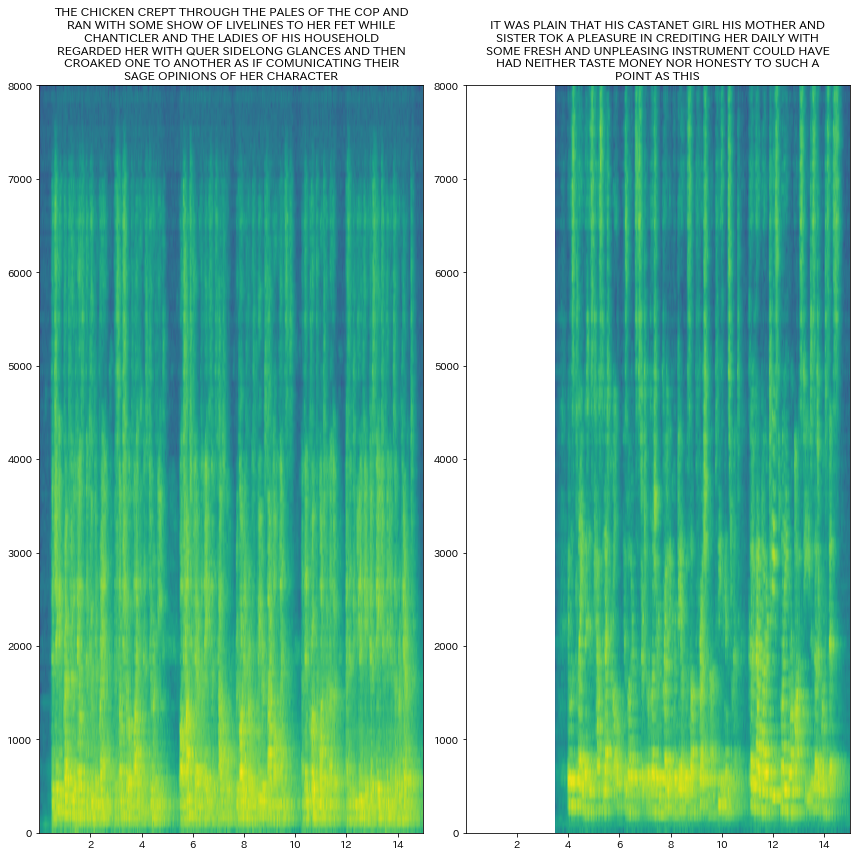

In [24]:
dls.show_batch(tok=tok, unique=False)

In [25]:
def wer(pred, labels):
    pred_logits = pred.logits
    pred_ids = np.argmax(pred_logits.detach().cpu().numpy(), axis=-1)
    pred_str = tok.batch_decode(pred_ids)
    label_str = tok.batch_decode(labels)
    wer = jiwer.wer(label_str, pred_str)
    return wer

def cer(pred, labels):
    pred_logits = pred.logits
    pred_ids = np.argmax(pred_logits.detach().cpu().numpy(), axis=-1)
    pred_str = tok.batch_decode(pred_ids)
    label_str = tok.batch_decode(labels)
    cer = jiwer.cer(label_str, pred_str)
    return cer


class TransformersLearner(Learner):
    def _do_one_batch(self):
        self.pred = self.model(self.xb[0], labels=cast(self.yb[0], torch.Tensor))
        self('after_pred')
        self.loss_grad = self.pred["loss"]
        self.loss = self.loss_grad.clone()
        self.smooth_loss = self.loss_grad.clone()
        self('after_loss')
        if not self.training or not len(self.yb): return
        self('before_backward')
        self.loss_grad.backward()
        self._with_events(self.opt.step, 'step', CancelStepException)
        self.opt.zero_grad()

In [26]:
%env NEPTUNE_API_TOKEN='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1YjMyZmIzZS0zNTEyLTQwNmMtYjUxNy05ZWI5NGY1MjQxMDYifQ=='

env: NEPTUNE_API_TOKEN='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1YjMyZmIzZS0zNTEyLTQwNmMtYjUxNy05ZWI5NGY1MjQxMDYifQ=='


In [27]:
logdir = Path("/content/drive/MyDrive/data/logs/audio_en/wav2vec2")
modelpath=Path("/content/drive/MyDrive/data/models/")

# neptune.init("jjs/itps-language-model")

cbs=[TensorBoardCallback(log_dir=logdir,trace_model=False,log_preds=False),
     SaveModelCallback(comp=np.less,
                       monitor="cer",
                       fname=Path(modelpath/ "audio_en"/"wav2vec2")), 
    #   MixedPrecisionTransformers(),
     ]

metrics = [Perplexity(), wer,cer]
learn = TransformersLearner(dls, model,
                loss_func=noop, # Loss is calculated in Transformers internally
                metrics=metrics,
                cbs=cbs)

In [28]:
import gc
torch.cuda.empty_cache()
gc.collect()

6228

In [30]:
dls.one_batch()

(TensorAudio([[-1.5259e-04, -1.5259e-04, -1.5259e-04,  ...,  1.5259e-04,
           1.2207e-04,  9.1553e-05],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.8311e-04,
           1.2207e-04,  3.0518e-05]], device='cuda:0'),
 TensorText([[ 6, 11,  5,  4, 19, 11, 10, 19, 26,  5,  9,  4, 19, 13,  5, 23,  6,  4,
           6, 11, 13,  8, 16, 21, 11,  4,  6, 11,  5,  4, 23,  7, 15,  5, 12,  4,
           8, 20,  4,  6, 11,  5,  4, 19,  8,  8, 23,  4,  7,  9, 14,  4, 13,  7,
           9,  4, 18, 10,  6, 11,  4, 12,  8, 17,  5,  4, 12, 11,  8, 18,  4,  8,
          20,  4, 15, 10, 25,  5, 15, 10,  9,  5, 12, 12,  4,  6,  8,  4, 11,  5,
          13,  4, 20,  5,  5,  6,  4, 18, 11, 10, 15,  5,  4, 19, 11,  7,  9,  6,
          10, 19, 15,  5,  5, 13,  4,  7,  9, 14,  4,  6, 11,  5,  4, 15,  7, 14,
          10,  5, 12,  4,  8, 20,  4, 11, 10, 12,  4, 11,  8, 16, 12,  5, 11,  8,
          15, 14,  4, 13,  5, 21,  7, 13, 14,  5, 14,  4, 11,  5, 13,  4, 18, 10,
           6, 11,  4, 30

AttributeError: 'TensorText' object has no attribute 'expandtabs'

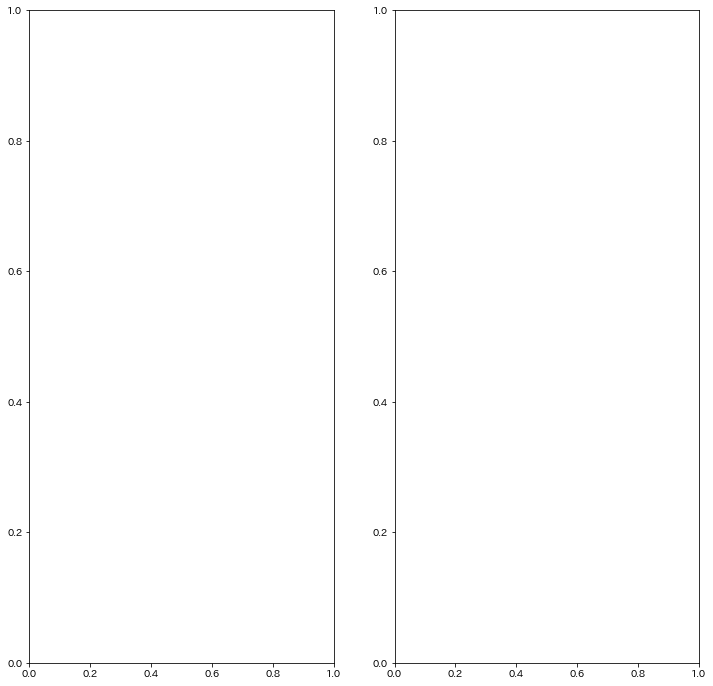

In [31]:
dls.show_batch()

/home/jjs/.conda/envs/itps-env/lib/python3.7/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


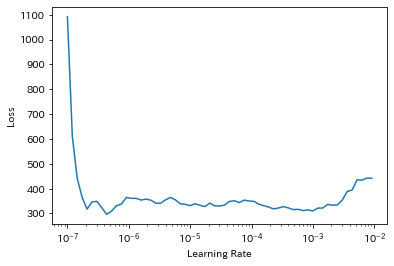

In [ ]:
start_lr=1e-7
end_lr=10
r = learn.lr_find(start_lr=start_lr,
                  end_lr=end_lr,
                  num_it=100,
                  stop_div=True,
                  suggest_funcs=())

In [ ]:
import json

if TEST_RUN:
  learn.fit_one_cycle(1,1e-3)
else:
#   neptune.create_experiment()
  model.freeze_feature_extractor()
  learn.fit_one_cycle(30,
                      lr_max=1e-4,
                    #   cbs=NeptuneCallback(log_model_weights=False)
                    cbs=cbs
                      )
  learn.save("/content/drive/MyDrive/data/models/wav2vecaug_cp_en_1b",
            with_opt=True)
  pretrained_save_path="/content/drive/MyDrive/data/models/wav2vecaug_pre_300m"
  learn.model.save_pretrained(pretrained_save_path)
  with open(Path(pretrained_save_path) / "en_vocab.json", "w") as f:
      json.dump(tok.tokenizer.get_vocab(), f)
  with open(Path(pretrained_save_path) / "tok.pkl", "wb") as f:
    pickle.dump(tok, f)
  learn.model = AutoModelForCTC.from_pretrained(
      # "/content/drive/MyDrive/data/models/audio_jp/",
      # pretrained_model_name,
      pretrained_save_path,
      attention_dropout=0.08,
      hidden_dropout=0.08,
      feat_proj_dropout=0.08,
      mask_time_prob=0.05,
      mask_feature_prob=0.05,
      layerdrop=0.08,
      # ctc_loss_reduction="mean", 
      ctc_zero_infinity=True,
      pad_token_id=tok.tokenizer.pad_token_id,
      vocab_size=len(tok.tokenizer),
  ).cuda()
  learn.fit_one_cycle(1,
                      lr_max=1e-4,
                      )
  learn.save("/content/drive/MyDrive/data/models/wav2vecaug_cp_en_300m",
            with_opt=True)
  learn.model.save_pretrained(pretrained_save_path)
  with open(Path(pretrained_save_path) / "en_vocab.json", "w") as f:
      json.dump(tok.tokenizer.get_vocab(), f)

epoch,train_loss,valid_loss,perplexity,wer,cer,time
0,484.983429,500.936432,inf,0.999693,0.949730,27:39
1,499.616028,494.516602,inf,0.999726,0.949509,24:26
2,502.884186,485.892365,inf,0.999739,0.950529,24:05
3,401.637512,376.047272,inf,1.050950,0.598049,23:39
4,280.799805,168.692657,inf,0.700128,0.287519,23:58
5,156.670547,66.700745,92846456864433060285767483392.000000,0.292970,0.116471,24:20
6,131.606583,49.616631,3533693434095894265856.000000,0.241873,0.097732,24:28
7,93.574944,31.610870,53508967497728.000000,0.226555,0.096050,24:29
8,101.867577,29.015659,3993380847616.000000,0.194752,0.077476,24:28
9,68.094666,23.945702,25089157120.000000,0.179798,0.075233,24:32


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 0 with cer value: 0.9497297680110305.
Better model found at epoch 1 with cer value: 0.9495085939041803.
Better model found at epoch 3 with cer value: 0.5980487538556782.
Better model found at epoch 4 with cer value: 0.2875190211299473.
Better model found at epoch 5 with cer value: 0.11647102962357797.
Better model found at epoch 6 with cer value: 0.09773168919890214.
Better model found at epoch 7 with cer value: 0.09605027702093526.
Better model found at epoch 8 with cer value: 0.07747591053018345.
Better model found at epoch 9 with cer value: 0.07523322775400358.
Better model found at epoch 10 with cer value: 0.0707213477860639.
Better model found at epoch 12 with cer value: 0.0666993723357995.


epoch,train_loss,valid_loss,perplexity,wer,cer,time
0,484.983429,500.936432,inf,0.999693,0.949730,27:39
1,499.616028,494.516602,inf,0.999726,0.949509,24:26
2,502.884186,485.892365,inf,0.999739,0.950529,24:05
3,401.637512,376.047272,inf,1.050950,0.598049,23:39
4,280.799805,168.692657,inf,0.700128,0.287519,23:58
5,156.670547,66.700745,92846456864433060285767483392.000000,0.292970,0.116471,24:20
6,131.606583,49.616631,3533693434095894265856.000000,0.241873,0.097732,24:28
7,93.574944,31.610870,53508967497728.000000,0.226555,0.096050,24:29
8,101.867577,29.015659,3993380847616.000000,0.194752,0.077476,24:28
9,68.094666,23.945702,25089157120.000000,0.179798,0.075233,24:32


Better model found at epoch 14 with cer value: 0.061457746245959496.
Better model found at epoch 16 with cer value: 0.05754397705081205.
Better model found at epoch 18 with cer value: 0.05599689194345213.
Better model found at epoch 19 with cer value: 0.05314973610294019.
Better model found at epoch 22 with cer value: 0.05180884671419718.
Better model found at epoch 23 with cer value: 0.049991900147210985.
Better model found at epoch 24 with cer value: 0.04819497789557927.
Better model found at epoch 25 with cer value: 0.04793163375304311.
Better model found at epoch 27 with cer value: 0.04705855540516656.
Better model found at epoch 28 with cer value: 0.04703204208168995.
Better model found at epoch 29 with cer value: 0.04697925748773736.


AttributeError: ignored

In [ ]:
if TEST_RUN:
  test_datasets = [
      DatasetConfig(name='librispeech', split='test', lang=None, kind='clean'),
      # DatasetConfig(name='librispeech', split='test', lang=None, kind='other'),
      # DatasetConfig(name='ljl', split='test', lang=None, kind=None),
      # DatasetConfig(name='nict_spreds', split='test', lang='en', kind=None¡£)
  ]
else:
  test_datasets = [
      DatasetConfig(name='librispeech', split='test', lang=None, kind='clean'),
      # DatasetConfig(name='librispeech', split='test', lang=None, kind='other'),
      # DatasetConfig(name='ljl', split='test', lang=None, kind=None),
      # DatasetConfig(name='nict_spreds', split='test', lang='en', kind=None)
  ]

In [ ]:
tp, tdf = get_datasets(test_datasets)

In [ ]:
tdf["audio_length"] = apply_parallel(tdf["filename"], get_audio_length, 16)
tdf = tdf[tdf["audio_length"]<15].reset_index(drop=True)
tdf = tdf[~tdf["text"].isna()].reset_index(drop=True)

abt = AudioBatchTransform()
t_tfms = TfmdLists(tdf, abt)

In [ ]:
if TEST_RUN:
  t_tfms = TfmdLists(tdf.iloc[:100], abt)
else:
  t_tfms = TfmdLists(tdf, abt)

In [ ]:
t_dl = dls.new(t_tfms)

In [ ]:
learn.cbs

In [ ]:
learn.remove_cb(learn.cbs[4]).validate(dl=t_dl)

In [ ]:
import pprint

In [ ]:
def get_preds(xs):
  preds=learn.model(xs)
  pred_logits=preds.logits
  pred_ids=TensorText(np.argmax(pred_logits.detach().cpu().numpy(), axis=-1))
  pred_str = tok.batch_decode(pred_ids)
  return pred_str
  
for xs, y in iter(t_dl):
  print(wer(learn.model(xs), y))
  print(cer(learn.model(xs), y))
  pprint.pprint(dict(enumerate(list(zip(get_preds(xs), tok.batch_decode(y))))))
  break


In [ ]:
comp = [(get_preds(xs), tok.batch_decode(y)) for xs, y in iter(t_dl)]

In [ ]:
for i, (x_pair, y_pair) in enumerate(comp):
  print("Pred: ", x_pair[0])
  print("Targ: ", y_pair[0])
  print("Pred: ", x_pair[1])
  print("Targ: ", y_pair[1])
  if (i+1 % 10) == 0:
    break


In [ ]:
if not TEST_RUN:
  learn.save("/content/drive/MyDrive/data/models/audio_en/export")
  with open("/content/drive/MyDrive/data/models/audio_en/export_tokenizer.pkl", "wb") as f:
    pickle.dump(tok, f)
  learn.model.save_pretrained("/content/drive/MyDrive/data/models/audio_en/")
  torch.save(learn.model, "/content/drive/MyDrive/data/models/audio_en/export_torch_model.pth")

In [ ]:
# neptune.stop()